## YOLO11 모델 파인튜닝 과정  
1) v1. 랜덤 가중치 학습  
2) v2. 추가 학습  
3) v3. COCO 가중치(사전 학습된 데이터셋)사용하여 학습  
4) v4. 백본 동결 후 파인튜닝  

---  

- **학습 결과 비교**  

| Model       | Precision (P) | Recall (R) | mAP@50 | mAP@50-95 | Inference Speed (it/s) |
|-------------|---------------|------------|--------|-----------|-------------------------|
| YOLO11s_v1  | 0.661         | 0.623      | 0.684  | 0.418     | 13.95                  |
| YOLO11s_v2  | 0.657         | 0.653      | 0.701  | 0.424     | 3.42                   |
| YOLO11s_v3  | 0.688         | 0.660      | 0.711  | 0.436     | 3.54                   |
| **YOLO11s_v4**  | **0.729**     | **0.630**  | **0.706**| **0.442** | **4.44**               |  

---  

- **선택 모델 버전: v4. 백본 동결 후 파인튜닝 버전**
  - Precision과 mAP@50-95가 가장 높아, 다양한 객체 크기에서도 정확한 예측 가능하다고 판단함  

---  
- **사용 데이터셋**  
  - Roboflow 공개 데이터셋: Billboard Dataset
  - 총 이미지: 3,399장 (Train: 2,719 / Valid: 510 / Test: 170)

In [ ]:
!pip install ultralytics
!pip install roboflow

In [ ]:
# 테스트 이미지 다운로드
!gdown 1JZA7_aM-k5-0N0kvvFLPcRI3RvRXo9zN  # test02.jpg
!gdown 1VaDFbs3YPmwO5foQHbM4a32QMGDOYAZm  # test03.jpg
!gdown 1uHkOEIMeeopf3AfhoCPfriXhLKkPNJBM # test04
!gdown 1JLNgO8GYuTZoAyJFHprDd1JZqC25Sq8M # test05
!gdown 1LTBmPwSoy6FVjhAS8ILFvaC7zUC4dFaI # test06

In [ ]:
import os
import cv2
import torch
import matplotlib.pyplot as plt
from ultralytics import YOLO
from roboflow import Roboflow

In [ ]:
# Roboflow 연결
rf = Roboflow(api_key="api_key")  # 본인의 API 키 입력

project = rf.workspace("arslan-ongr8").project("billboard-xlvz1")
version = project.version(1)
dataset = version.download("yolov11")

print(f"Data YAML Path: {dataset.location}/data.yaml")

### v1. 랜덤 가중치 학습   

In [ ]:
# Load a model
model = YOLO("yolo11s.pt")

# Train the model
train_results = model.train(
    data="/content/Billboard-1/data.yaml",  # path to dataset YAML
    epochs=20,  # number of training epochs
    imgsz=640,  # training image size
    batch=8,
    workers=4,
    mosaic=0.0,
    name="billboard_detect",  # 학습 결과 폴더명
    pretrained=False,
    amp=False,
    device="cuda",
)

# Evaluate model performance on the validation set
metrics = model.val()

# Perform object detection on an image
results = model("/content/test02.jpg")
results[0].show()

### v2. 추가학습  

In [ ]:
# 기존 학습된 모델(last.pt)
model = YOLO("/content/runs/detect/billboard_detect3/weights/last.pt")

# 기존 학습된 모델에서 추가 학습 진행
train_results = model.train(
    data="/content/Billboard-1/data.yaml",
    epochs=20,   # 기존 학습(20) + 추가 학습(20) -> 총 40 epoch
    imgsz=960,   # 작은 객체 탐지를 위해 이미지 크기 증가
    batch=16,    # 배치 크기 증가
    mosaic=0.5,  # 데이터 증강 활성화
    name="billboard_detect_v2",  # 새 폴더에 저장 (이전과 구분)
    pretrained=False,            # last.pt를 사용하므로 False (이어 학습)
    amp=True,
    device="cuda",
)

# Evaluate model performance on the validation set
metrics = model.val()

# Perform object detection on an image
results = model("/content/test02.jpg")
results[0].show()

# Export the model to ONNX format
path = model.export(format="onnx")  # return path to exported model

### v3. COCO 가중치를 사용하여 학습  

In [ ]:
# YOLOv11 모델 로드
model = YOLO("yolo11s.pt")

train_results = model.train(
    data="/content/Billboard-1/data.yaml",
    epochs=50,
    imgsz=960,   # 해상도 증가하여 작은 광고도 탐지 가능하게 조정
    batch=16,    # 배치 크기 증가
    workers=4,   # 데이터 로딩 최적화
    mosaic=0.5,  # 데이터 증강 활성화
    name="billboard_detect",
    pretrained=True,  # COCO 가중치 활용하여 빠른 수렴 유도
    amp=True,    # 자동 혼합 정밀도 활성화 (학습 속도 향상)
    device="cuda",
)

# 검증 데이터셋 성능 평가
metrics = model.val()

# 테스트 이미지에 대해 YOLOv11 객체 탐지 수행
test_image = "/content/test02.jpg"
results = model(test_image)

# 바운딩 박스 정보 추출
boxes = results[0].boxes.xyxy.cpu().numpy()        # (x1, y1, x2, y2)
confidences = results[0].boxes.conf.cpu().numpy()  # 신뢰도

results[0].show()

### v4. 백본 동결 후 파인튜닝  

In [ ]:
# Load a model
model = YOLO("yolo11s.pt")

print(model.model) # yolo11 모델 구조 확인

In [ ]:
model = YOLO("yolo11s.pt")

# Backbone 찾기 -> 초반 레이어 (Conv, C3) 동결
for layer in list(model.model.children())[:9]:  # 앞 9개 레이어 동결
    for param in layer.parameters():
        param.requires_grad = False

results = model.train(
    data="/content/Billboard-1/data.yaml",
    epochs=20,  # YOLO 헤드만 학습
    imgsz=640,
    batch=16,
    freeze=9    # 백본 0~8번 레이어 동결
)

In [ ]:
# 1단계 학습한 best.pt 모델 로드
model = YOLO("/content/runs/detect/train2/weights/best.pt")

# Backbone 가중치 해제
for layer in list(model.model.children())[:9]:
    for param in layer.parameters():
        param.requires_grad = True

# Fine-Tuning-백본 포함 전체 학습
results = model.train(
    data="/content/Billboard-1/data.yaml",
    epochs=50,
    imgsz=640,
    batch=16,
    lr0=0.0001,
    patience=10,
    seed=1234  # 재현성을 위해 seed 설정
)

In [ ]:
# 성능평가
model = YOLO("runs/detect/train3/weights/best.pt")
metrics = model.val()

Ultralytics 8.3.80 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs


val: Scanning /content/Billboard-1/valid/labels.cache... 510 images, 0 backgrounds, 0 corrupt: 100%|██████████| 510/510 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.44it/s]


                   all        510       1404      0.729       0.63      0.706      0.442
Speed: 0.6ms preprocess, 9.0ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/val



image 1/1 /content/test06.jpg: 448x640 7 billboards, 52.0ms
Speed: 2.3ms preprocess, 52.0ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


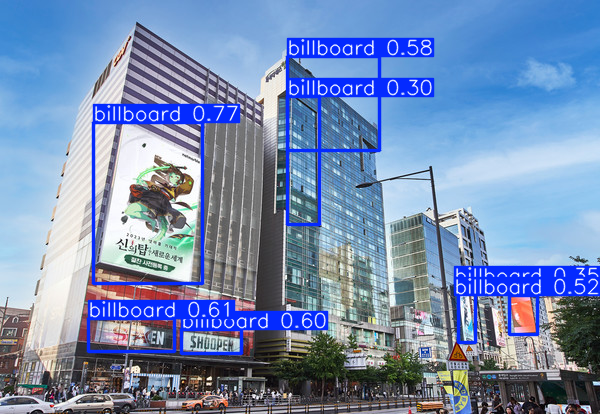

In [ ]:
# 테스트
results = model("/content/test06.jpg")
results[0].show()

#### 모델 저장
- 신뢰도가 높은 객체만 표시  


image 1/1 /content/test06.jpg: 448x640 7 billboards, 12.8ms
Speed: 1.9ms preprocess, 12.8ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


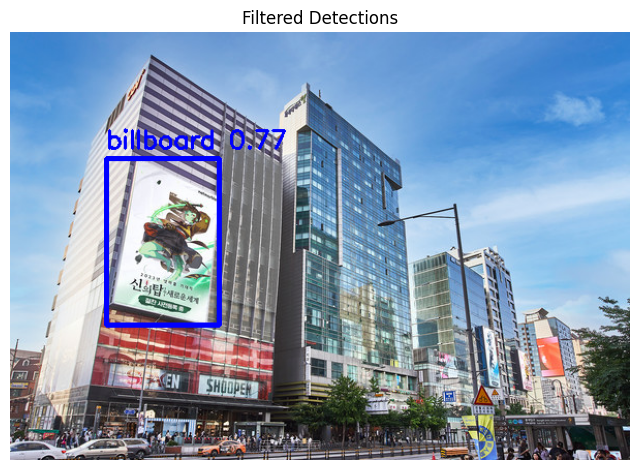

In [ ]:
model = YOLO("/content/best-0228.pt")

image_path = "/content/test06.jpg"

# 객체 탐지 수행 신뢰도가 가장 높은 객체 선택
results = model(image_path)
detections = results[0]

if len(detections.boxes) > 0:
    best_box = max(detections.boxes, key=lambda box: box.conf.item())

    # Bounding Box 좌표 및 클래스 정보
    x1, y1, x2, y2 = map(int, best_box.xyxy[0].tolist())
    conf = best_box.conf.item()
    class_id = int(best_box.cls.item())
    class_name = results[0].names[class_id]

    # 가장 큰 객체 Bounding Box 표시
    img = cv2.imread(image_path)
    color = (255, 0, 0)
    cv2.rectangle(img, (x1, y1), (x2, y2), color, 3)
    label = f"{class_name} {conf:.2f}"
    cv2.putText(img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)

plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Filtered Detections")
plt.axis("off")
plt.show()